**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Aprendizaje Automático**

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 23 de octubre 2025, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Nota Introductoria.

Usted puede cambiar los datasets que se le proporcionan por otros de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus datasets no le agreguen una complicación importante al Trabajo Práctico.

___

# Parte 1 - Regresión (50 puntos)

___

# Introducción

Considere:
- Se le proporciona un conjunto de datos (diamonds), si desea conocer un poco de los atributos puede consultar en: <https://www.kaggle.com/datasets/shivam2503/diamonds>
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación. Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: price.
- Debe comentar ampliamente su código

In [30]:
from __future__ import annotations

import math
from typing import Any, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas import DataFrame, DatetimeIndex, Series
from pandas.plotting import lag_plot
from prophet import Prophet
from prophet.models import StanBackendEnum
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold

sns.set_theme(style="whitegrid")
set_config(transform_output="pandas")

### 1 (5 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atributos.

---

En el siguiente bloque de código leemos el archivo `diamonds.csv` como un `DataFrame` de nombre `df`. Adicionalmente, convertimos la variable `cut` a tipo categórico para facilitar su análisis.

In [3]:
df = pd.read_csv("./data/diamonds.csv")
df["cut"] = df["cut"].astype("category")

**Nota:** en el archivo original la variable `cut` está codificada con valores enteros del 0 al 4. Al convertirla en categórica mantenemos esa codificación, pero conservamos un listado de etiquetas descriptivas para emplearlas en los gráficos. También utilizamos una variable `column_labels` para mapear los nombres de las columnas a etiquetas más descriptivas.

In [4]:
cut_labels = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
cut_order = df["cut"].cat.categories.tolist()

column_labels = {
    "carat": "Quilates (carat)",
    "depth": "Profundidad (%)",
    "table": "Tabla (%)",
    "x": "Largo (mm)",
    "y": "Ancho (mm)",
    "z": "Altura (mm)",
    "price": "Precio (USD)",
}

Con el siguiente bloque de código podemos observar que el `DataFrame` tiene 53940 filas, ninguna de las cuales contiene valores nulos.

In [5]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   carat   53940 non-null  float64 
 1   depth   53940 non-null  float64 
 2   table   53940 non-null  float64 
 3   price   53940 non-null  int64   
 4   x       53940 non-null  float64 
 5   y       53940 non-null  float64 
 6   z       53940 non-null  float64 
 7   cut     53940 non-null  category
dtypes: category(1), float64(6), int64(1)
memory usage: 2.9 MB


Con el siguiente bloque de código podemos observar las primeras 5 filas del `DataFrame`.

In [6]:
df.head(5)

,carat,depth,table,price,x,y,z,cut
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1


#### Mapa de correlaciones

El primer gráfico que vamos a generar es uno para observar la correlación entre los atributos del `DataFrame`.

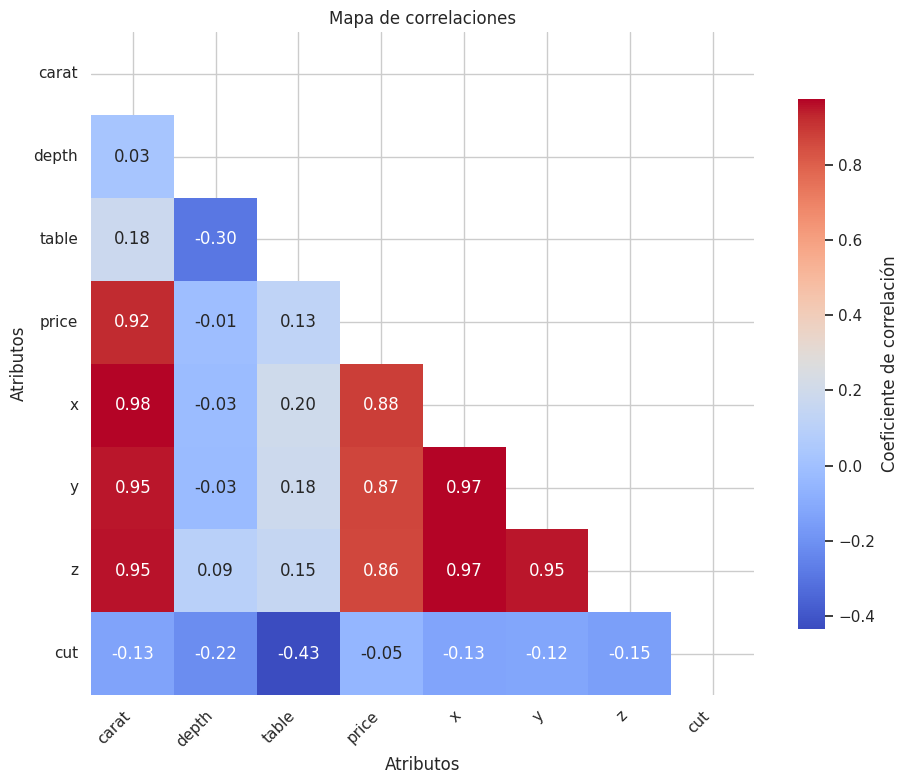

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Coeficiente de correlación", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Mapa de correlaciones")
plt.xlabel("Atributos")
plt.ylabel("Atributos")
plt.tight_layout()
plt.show()

Con este gráfico podemos observar que los atributos `x`, `y` y `z` (las dimensiones del diamante) están altamente correlacionados entre sí y con `carat` (el peso del diamante). Además, `carat` tiene una alta correlación con `price` (el precio del diamante). Esto tiene sentido, ya que los diamantes están formados de un mismo material, así que no habrá grandes variaciones en su densidad, por lo que el peso y las dimensiones están estrechamente relacionados.

Debido a esta alta correlación podríamos considerar unificar los atributos `x`, `y` y `z` en una sola variable `volume` (el volumen del diamante), o incluso descartarlos, ya que estos están altamente relacionados con `carat`, por lo que no temeríamos perder información al hacerlo.

Al mismo tiempo podemos ver que los atributos como `depth`, `table` y `cut` tienen una relación más débil y podrían no ser predictores significativos.

#### Diagramas de dispersión

A continuación generamos diagramas de dispersión de las variables numéricas comparadas con `price`, la cual es la variable que deseamos predecir. Esto con el fin de analizar si existe una tendencia lineal entre los datos correlacionados y revisar el comportamiento de los datos con relación más baja.


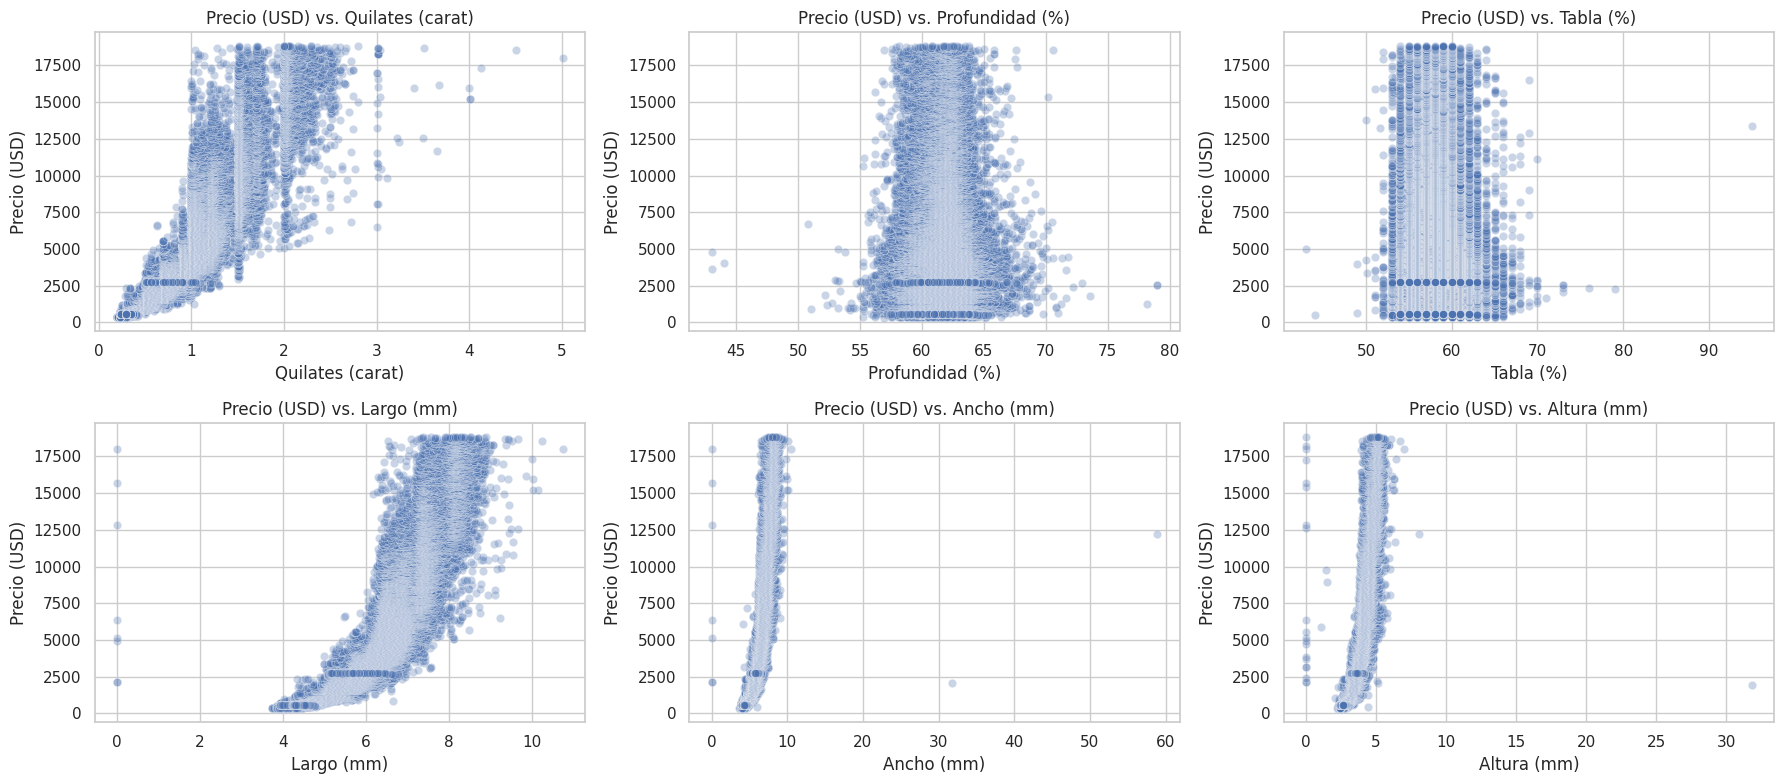

In [8]:
num_cols = df.select_dtypes(include="number").columns.drop("price")
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=df, alpha=0.3, ax=ax)
    ax.set_title(f"Precio (USD) vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

De estos gráficos se puede apreciar lo siguiente:
- `carat` presenta una correlación positiva con respecto a `price`. Tiende a dispersarse mucho en los precios más altos y se llega a un pico de aumento. Este es un buen punto para escalar los datos de `price` para rectificar la curva y aclarar la varianza.
- `x`, `y` y `z` presentan correlaciones positivas afectadas por posibles outliers y valores extraños como el 0 en sus dimensiones. Idealmente se deberían descartar esos valores.
- La correlación de `table` y `depth`, como vimos anteriormente, es muy baja y no se nota ninguna tendencia (positiva o negativa) en los datos. Se podrían descartar estas columnas como predictores.

#### Diagramas de cajas

A continuación se muestra un diagrama de cajas de `price` contra `cut`, que es una variable categórica.

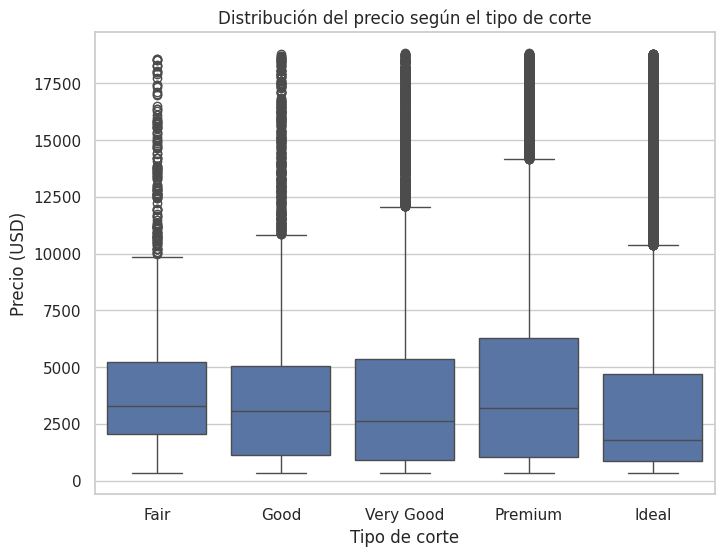

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

El tipo de corte (la variable `cut`) influye muy poco en el precio y parece que solo introduce valores atípicos, ya que hay muchos diamantes con precios mayores de lo que se esperaría. No es el predictor más fuerte, pero puede que influya como valor categórico.

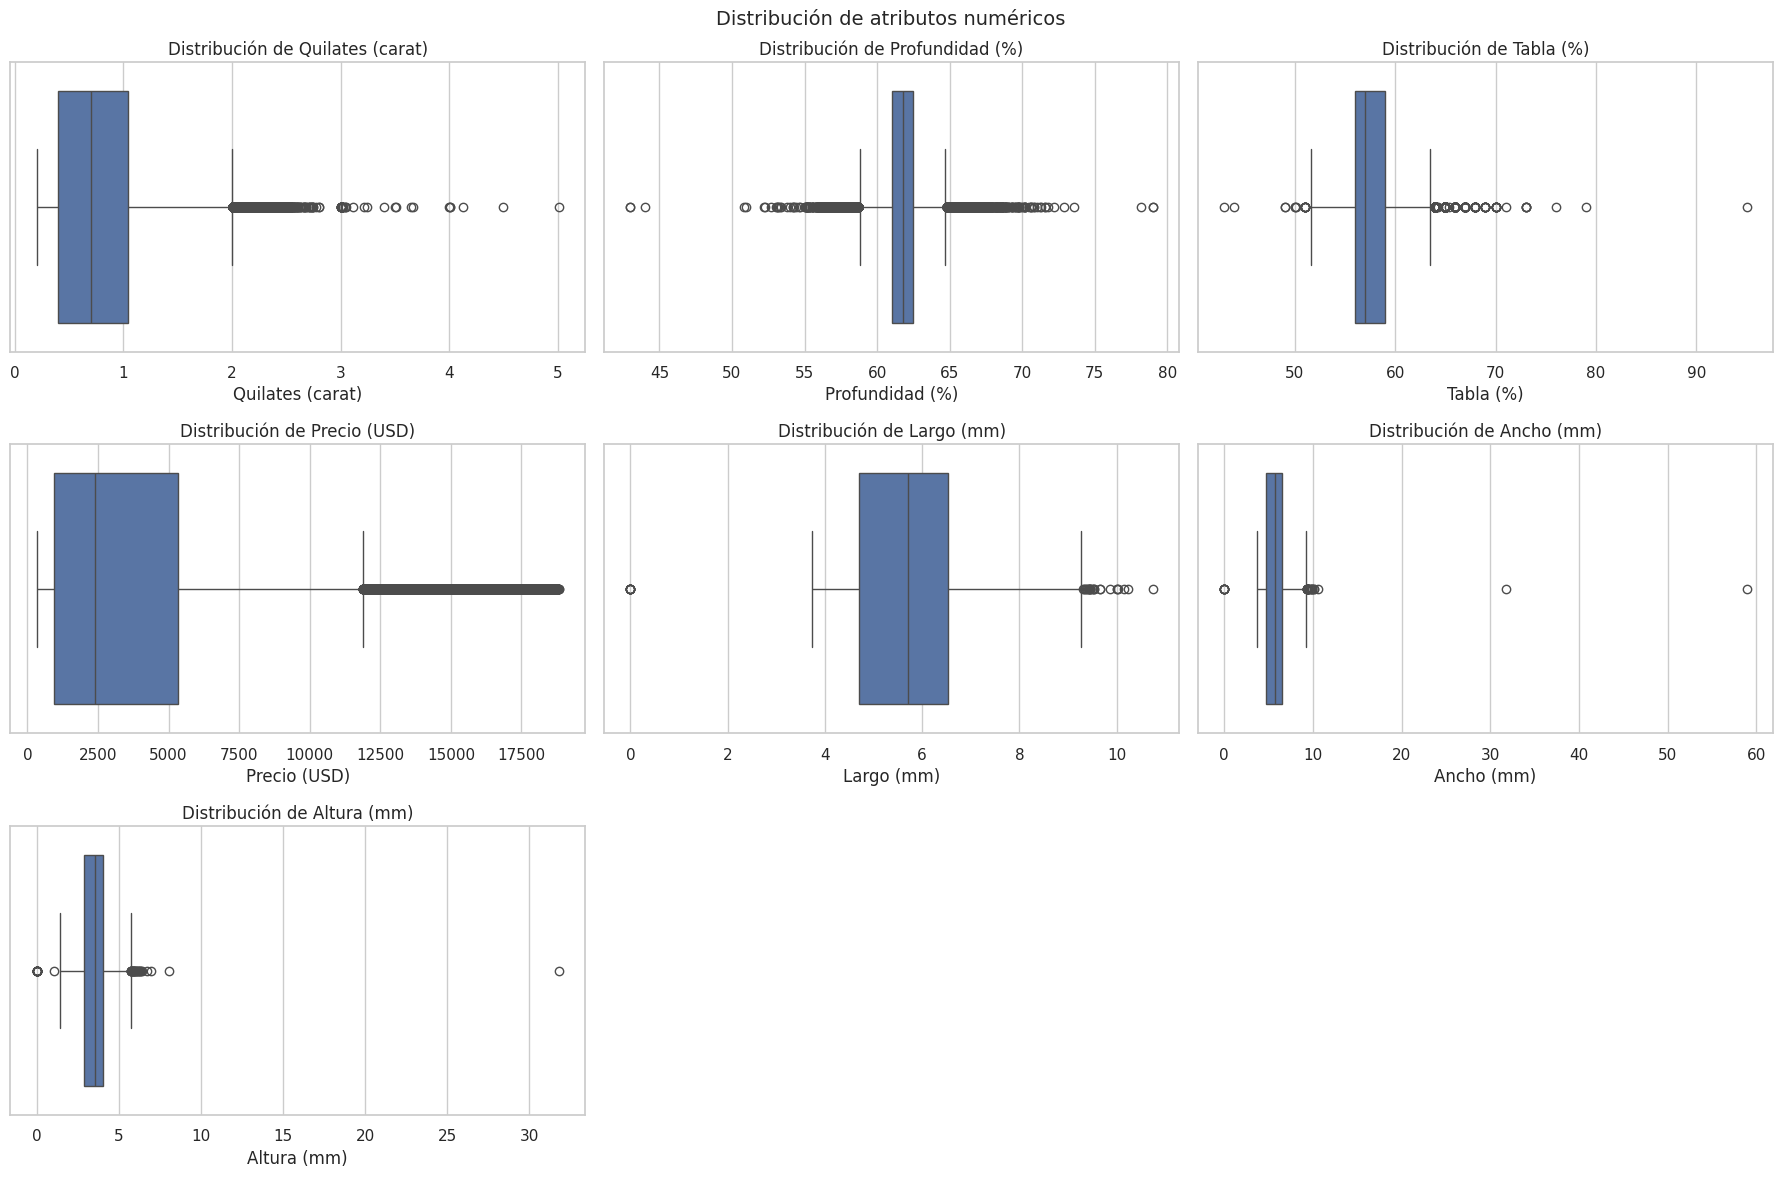

In [10]:
num_cols = df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos", fontsize=14)
fig.tight_layout()
plt.show()

En estos diagramas de cajas puede apreciar que:
- `price` y `carat` presentan colas largas hacia la derecha. La mayor parte de los diamantes es barata y hay una cola de diamantes caros. Esto implica que muchos de los outliers por IQR no son errores, sino la realidad del mercado.
- `depth` y `table` están bastante concentrados cerca de 60, con algunos outliers a ambos lados, los cuales son posibles pero hay que tratar con cautela.
- `x`, `y` y `z` muestran valores imposibles (cercanos a 0) y extremos gigantes. Estos podrían ser posibles errores y deben filtrarse.

#### Histogramas

Finalmente revisamos el comportamiento de las variables mediante el uso de histogramas:

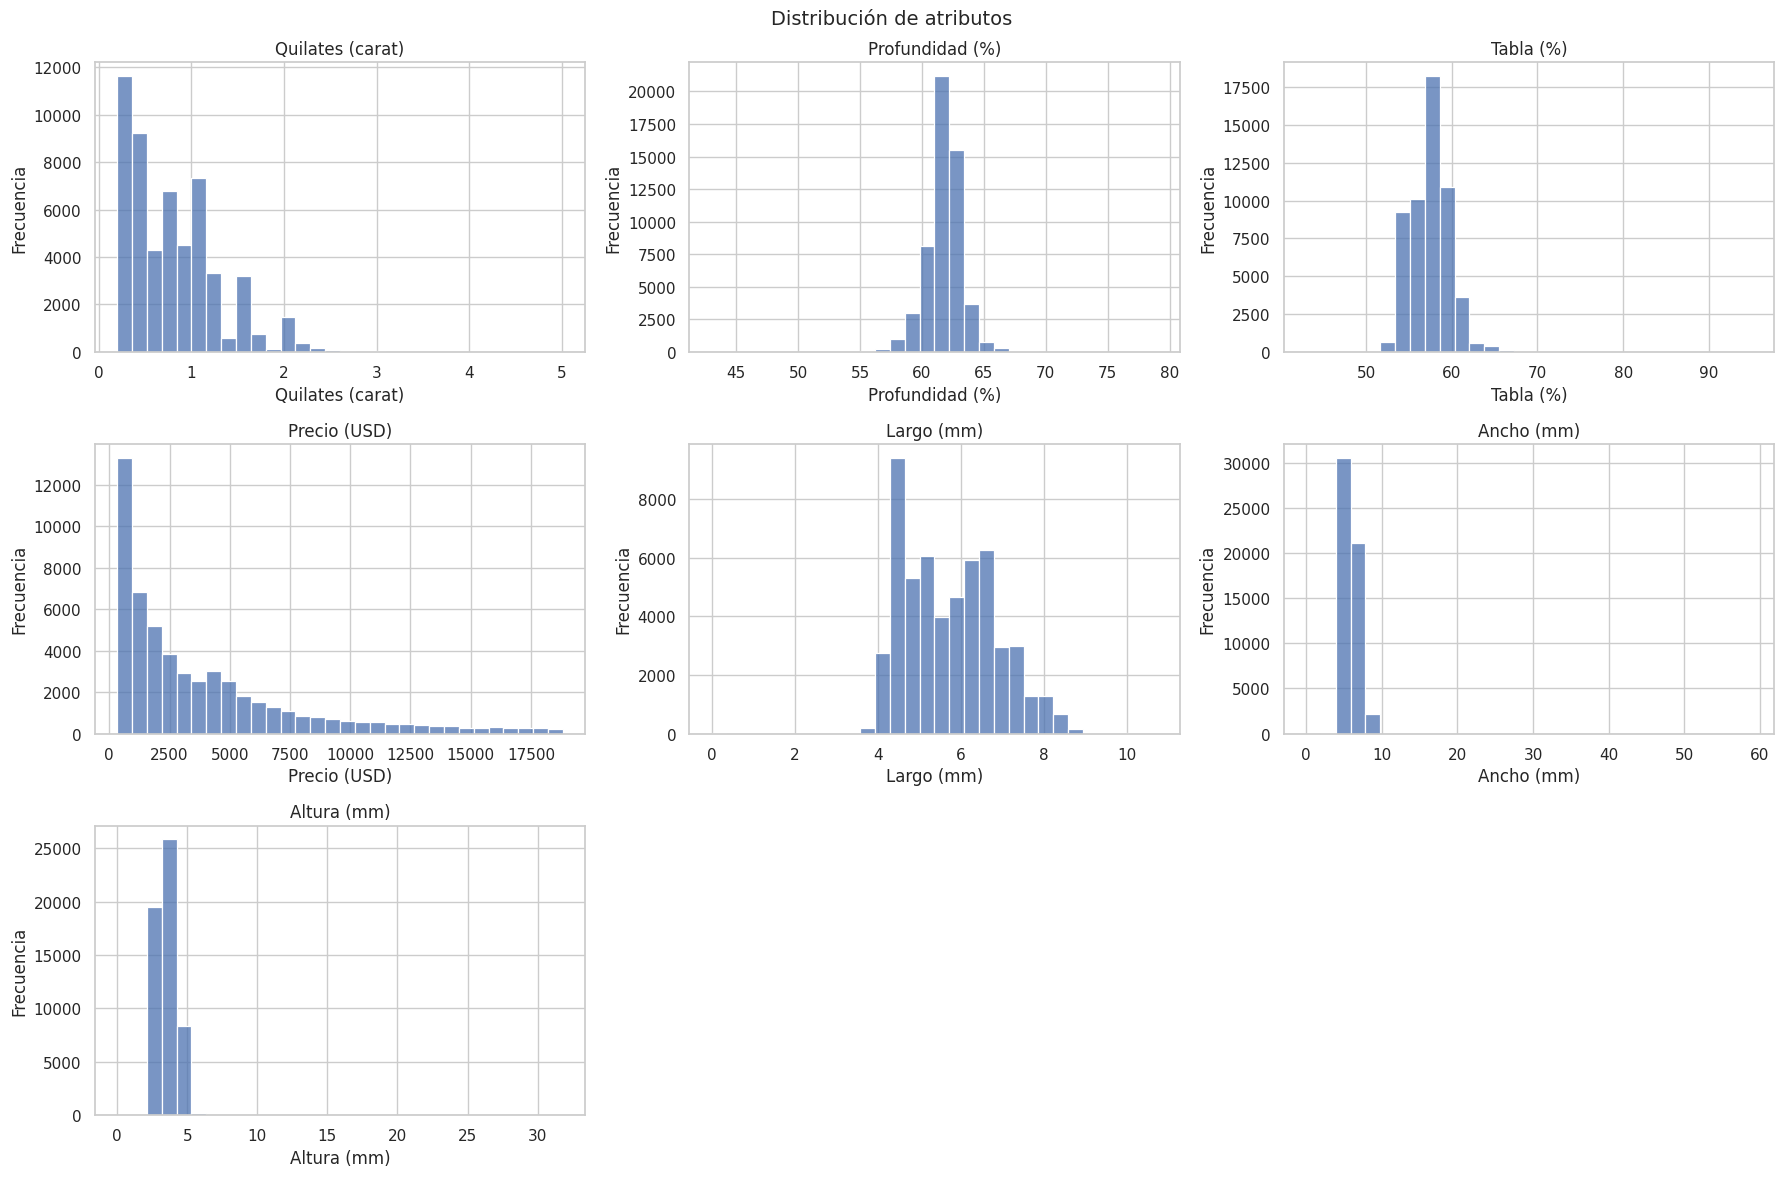

In [11]:
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos", fontsize=14)
fig.tight_layout()
plt.show()

Estos histogramas confirman nuestras observaciones anteriores.

### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%) y Test (30%).
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe los conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.

---

Para los parámetros mencionados se tomaron las siguientes decisiones:
- `shuffle`: el `DataFrame` no tiene una dependencia en el orden de sus datos y, como los datos más determinantes para la predicción tienden a valores más bajos, es beneficioso barajar las filas para evitar que el `train` o `test` solo contengan estos valores, es decir, para que haya una mejor distribución.
- `random_state`: debido a la naturaleza del trabajo práctico se desea tener reproducibilidad en las ejecuciones, especialmente porque se está trabajando en grupo. Debido a esto definir el valor del `random_state` es necesario para asegurar que la división sea la misma en varias ejecuciones, se escogió el número 42 por ser uno de los más comunes en ejemplos de regresión.

In [12]:
x = df.drop("price", axis=1)
y = df["price"]

x_train_raw, x_test_raw, y_train_raw, y_test_raw = cast(
    tuple[DataFrame, DataFrame, Series, Series],
    train_test_split(x, y, test_size=0.30, random_state=42, shuffle=True),
)

In [13]:
display(x_train_raw.head(5))
display(x_test_raw.head(5))
display(y_train_raw.head(5))
display(y_test_raw.head(5))

,carat,depth,table,x,y,z,cut
19497,1.21,61.3,57.0,6.92,6.87,4.23,4
31229,0.31,62.0,56.0,4.38,4.36,2.71,4
22311,1.21,62.4,57.0,6.75,6.83,4.24,4
278,0.81,62.6,55.0,5.92,5.96,3.72,4
6646,0.79,61.7,56.0,5.94,5.95,3.67,4


,carat,depth,table,x,y,z,cut
1388,0.24,62.1,56.0,3.97,4.00,2.47,4
50052,0.58,60.0,57.0,5.44,5.42,3.26,2
41645,0.40,62.1,55.0,4.76,4.74,2.95,4
42377,0.43,60.8,57.0,4.92,4.89,2.98,3
17244,1.55,62.3,55.0,7.44,7.37,4.61,4


,price
19497,8131
31229,756
22311,10351
278,2795
6646,4092


,price
1388,559
50052,2201
41645,1238
42377,1304
17244,6901


### 3 (10 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

---

Primero mostremos la cantidad de datos que hay en cada conjunto antes de remover datos duplicados, outliers y datos inválidos.

In [14]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_raw)} filas.
El conjunto de prueba tiene {len(x_test_raw)} filas.
""")


El conjunto de entrenamiento tiene 37758 filas.
El conjunto de prueba tiene 16182 filas.



#### Eliminación de datos duplicados

Al eliminar filas duplicadas se mejora la integridad del modelo y se evita sobrerepresentar ciertas observaciones, esto puede servir en el caso de diamantes ya que la predicción puede ser afectada por el precio de mercado especialmente en los valores de `carat` bajos.

In [15]:
x_train_no_dups = x_train_raw.drop_duplicates()
x_test_no_dups = x_test_raw.drop_duplicates()

y_train_no_dups = y_train_raw.loc[x_train_no_dups.index]
y_test_no_dups = y_test_raw.loc[x_test_no_dups.index]

#### Remoción de outliers y datos inválidos

Estos datos como $x,y,z = 0$ o dimensiones no realistas pueden afectar al modelo e introducir ruido, por lo que se decidió filtrarlos. También se decidió filtrar los valores fuera del rango intercuartílico (IQR) para las dimensiones `x`, `y` y `z`, ya que estos pueden ser _outliers_.

In [16]:
xyz_cols = ["x", "y", "z"]
xyz_quartiles = x_train_no_dups[xyz_cols].quantile([0.25, 0.75])
xyz_iqr = xyz_quartiles.loc[0.75] - xyz_quartiles.loc[0.25]
xyz_bounds = pd.DataFrame(
    {
        "lower": xyz_quartiles.loc[0.25] - 1.5 * xyz_iqr,
        "upper": xyz_quartiles.loc[0.75] + 1.5 * xyz_iqr,
    }
)


def quality_filter(df: DataFrame, bounds: DataFrame) -> Series:
    base_mask = (
        (df["carat"] > 0)
        & (df["x"] > 0)
        & (df["y"] > 0)
        & (df["z"] > 0)
        & (df["depth"].between(40, 80))
        & (df["table"].between(40, 80))
    )
    xyz_mask = (df[xyz_cols].ge(bounds["lower"]) & df[xyz_cols].le(bounds["upper"])).all(axis=1)
    return base_mask & xyz_mask


train_quality_mask = quality_filter(x_train_no_dups, xyz_bounds)
test_quality_mask = quality_filter(x_test_no_dups, xyz_bounds)

x_train_filtered = x_train_no_dups.loc[train_quality_mask]
y_train_filtered = y_train_no_dups.loc[train_quality_mask]
x_test_filtered = x_test_no_dups.loc[test_quality_mask]
y_test_filtered = y_test_no_dups.loc[test_quality_mask]

La función `quality_filter` encapsula todos los criterios vigentes (valores mínimos razonables, rangos válidos de `depth` y `table`, además de los límites basados en el IQR de `x`, `y` y `z`). Los umbrales del IQR se calculan únicamente con el conjunto de entrenamiento para evitar fugas de información hacia el conjunto de prueba; posteriormente se reutilizan para filtrar ambos subconjuntos de manera consistente.

Con el código a continuación podemos observar la cantidad de datos que hay en cada conjunto después de remover datos duplicados, outliers y datos inválidos.

In [17]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_filtered)} filas.
El conjunto de prueba tiene {len(x_test_filtered)} filas.
""")


El conjunto de entrenamiento tiene 36290 filas.
El conjunto de prueba tiene 15864 filas.



#### Gráficos después de la limpieza

##### Diagramas de dispersión

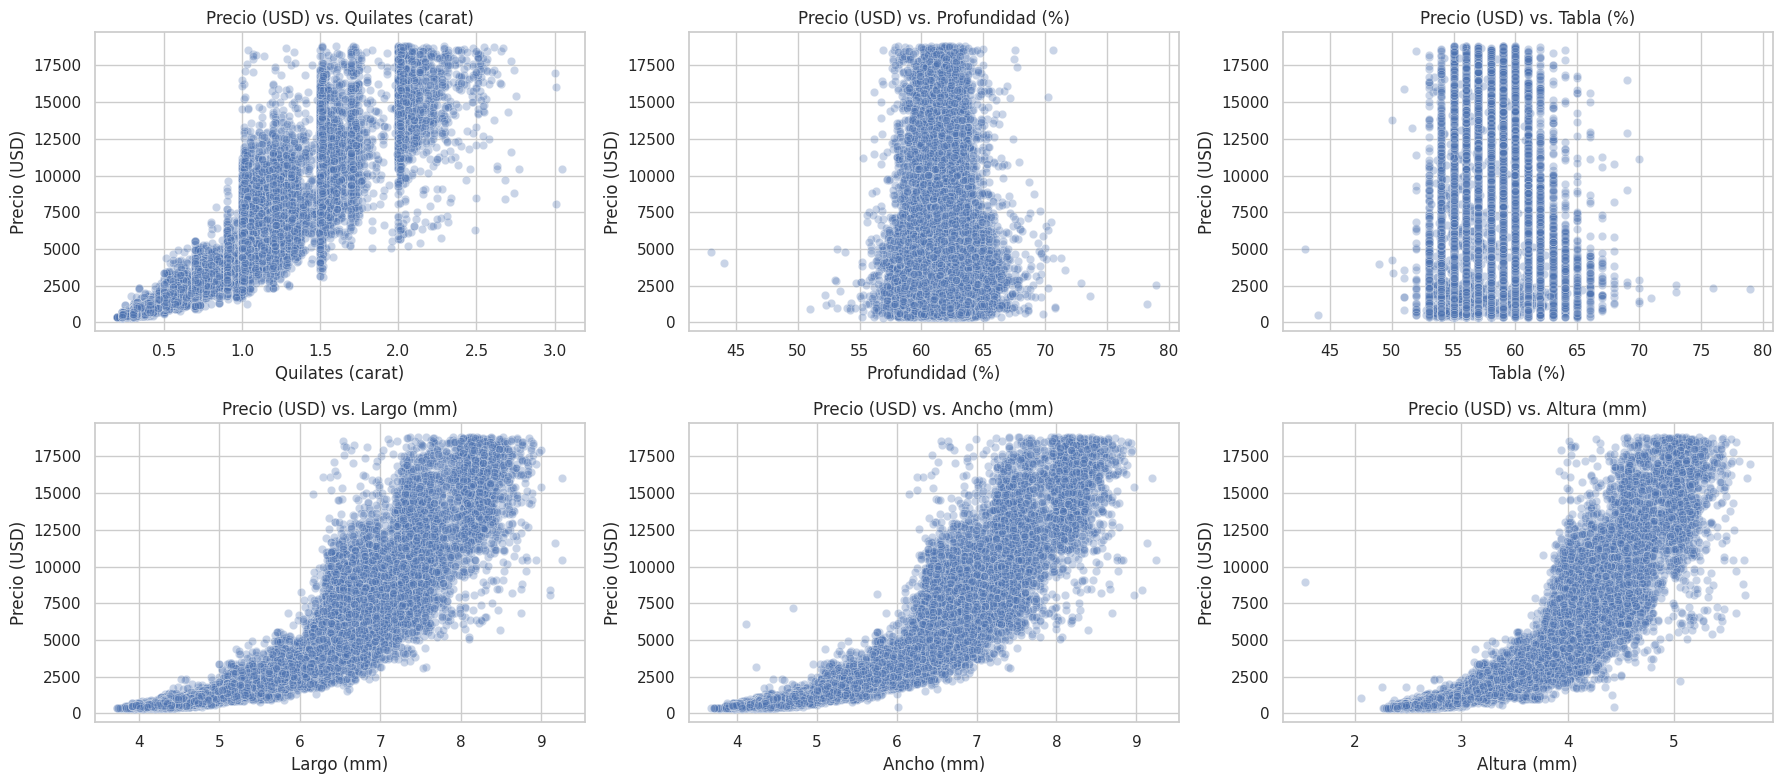

In [18]:
train_df = x_train_filtered.copy()
train_df["price"] = y_train_filtered

num_cols = x_train_filtered.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=train_df, alpha=0.3, ax=ax)
    ax.set_title(f"{column_labels['price']} vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

##### Diagramas de cajas

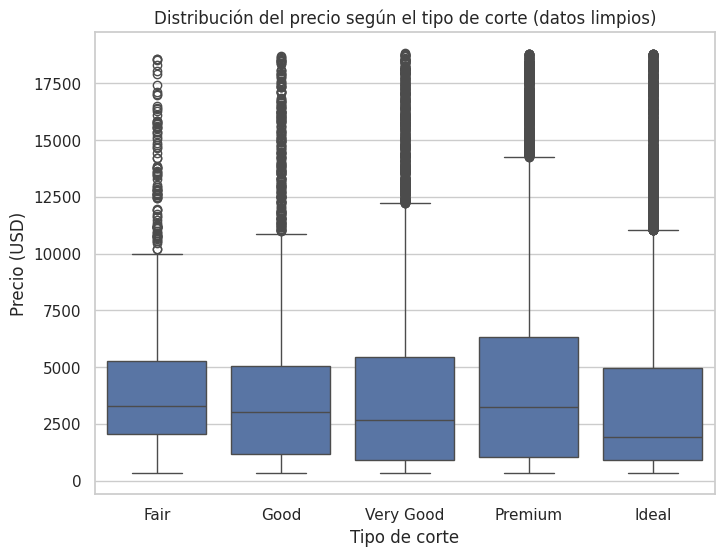

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=train_df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte (datos limpios)")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

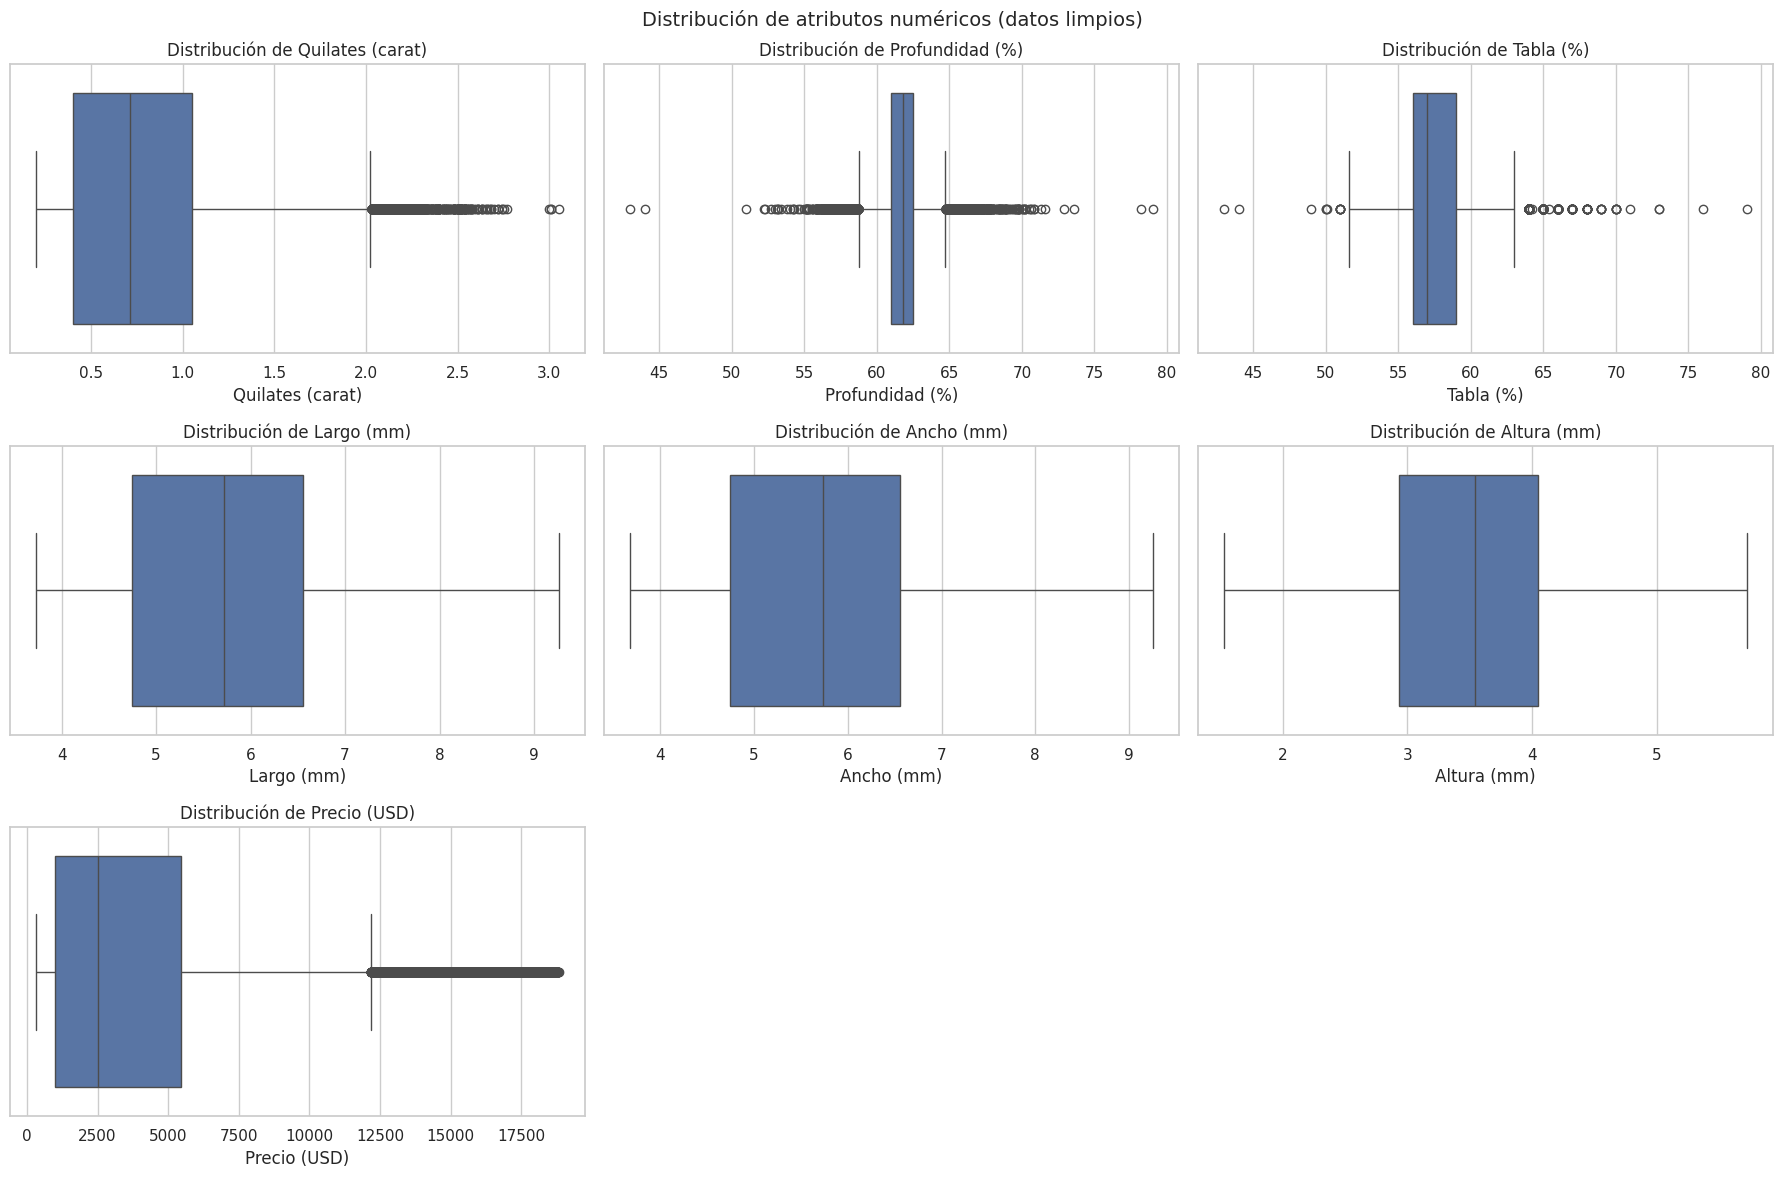

In [20]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=train_df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

##### Histogramas

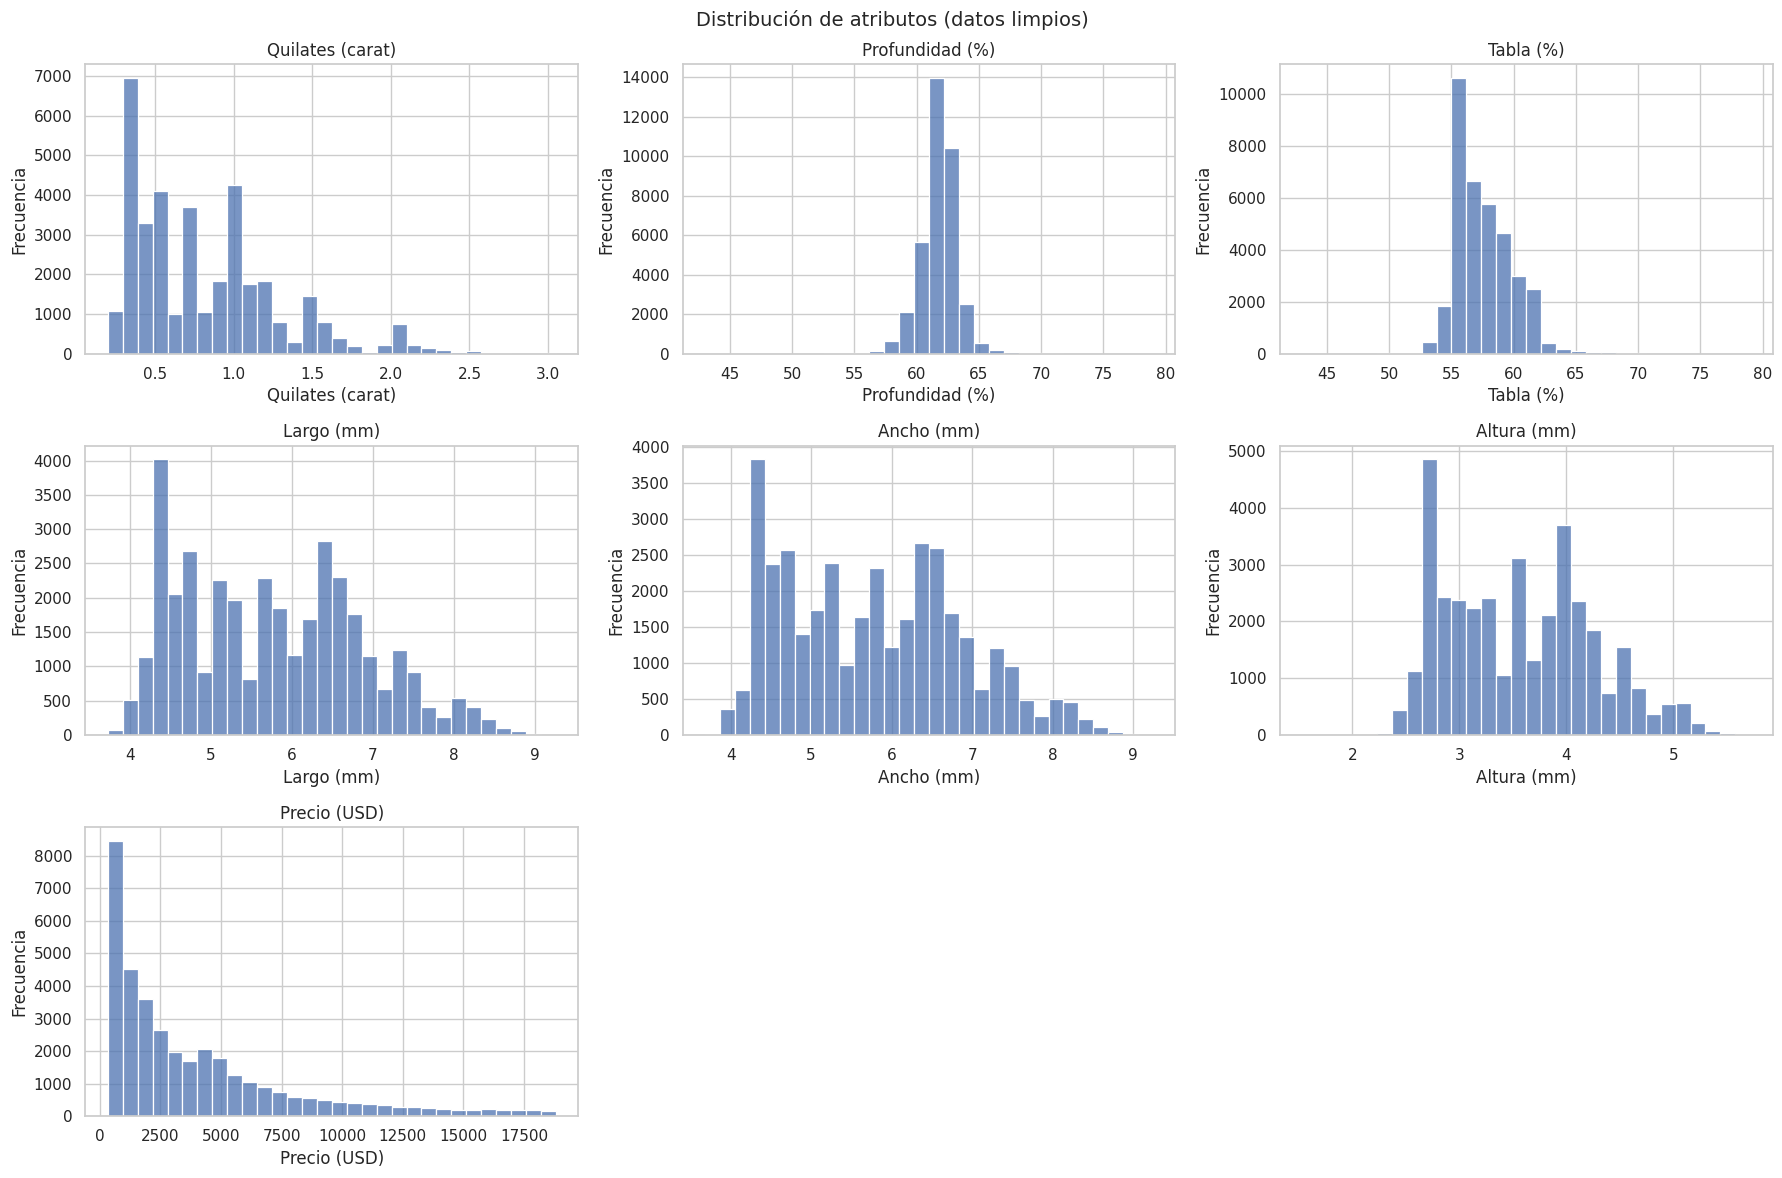

In [21]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=train_df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

### 4 (5 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- Comente sus conclusiones.

---

La técnica que deseamos utilizar para la selección de atributos es la de _Filter_, ya que es una técnica sencilla y con el análisis previo pudimos observar que varios atributos no aportan información significativa para la predicción del precio.

Con el código a continuación podemos observar la correlación entre los diferentes atributos del `DataFrame` y `price`. Se debe tomar en consideración que esta es la misma correlación que se mostró anteriormente.

In [22]:
corr_with_price = train_df.corr()["price"].drop("price")

correlation_table = (
    corr_with_price.to_frame(name="correlación")
    .assign(correlación_abs=lambda df_: df_["correlación"].abs())
    .sort_values("correlación_abs", ascending=False)
)

display(correlation_table)

,correlación,correlación_abs
carat,0.922755,0.922755
y,0.887984,0.887984
x,0.886648,0.886648
z,0.881958,0.881958
table,0.108540,0.108540
cut,-0.039369,0.039369
depth,-0.003236,0.003236


Esta tabla muestra que los atributos `carat`, `x`, `y` y `z` tienen una correlación significativa con `price`, pero a como vimos anteriormente, `x`, `y` y `z` están altamente correlacionados entre sí y con `carat`. Por lo tanto, se decidió conservar solo `carat` y eliminar `x`, `y` y `z`.

Para no eliminar más atributos, se decidió conservar `cut` y `table`, ya que aunque su correlación es baja pueden aportar información adicional al modelo. Se decidió conservar específicamente `cut` y `table` porque son los que más correlación tienen con `price` de los atributos restantes. Esto nos da como resultado el Top #3 de atributos más correlacionados con `price`.

In [23]:
x_train_selected = x_train_filtered.drop(columns=["x", "y", "z", "depth"])
x_test_selected = x_test_filtered.drop(columns=["x", "y", "z", "depth"])

### 1.5 (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'diamondsPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).

---

Con el código a continuación se realiza el escalamiento de los datos.

In [24]:
numeric_cols = ["carat", "table"]
categorical_cols = ["cut"]

log1p_numeric = FunctionTransformer(lambda data: data.assign(carat=np.log1p(data["carat"])), validate=False)
numeric_pipeline = Pipeline(steps=[("log1p", log1p_numeric), ("scaler", MinMaxScaler())])

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))]
)

diamonds_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols),
    ],
    verbose_feature_names_out=False,
)

x_train = cast(DataFrame, diamonds_preprocessor.fit_transform(x_train_selected))
x_test = cast(DataFrame, diamonds_preprocessor.transform(x_test_selected))

y_train_log = np.log1p(y_train_filtered)
y_test_log = np.log1p(y_test_filtered)

diamonds_train_processed = x_train.assign(price_log=y_train_log, price=y_train_filtered, split="train")
diamonds_test_processed = x_test.assign(price_log=y_test_log, price=y_test_filtered, split="test")
diamonds_processed = (
    pd.concat([diamonds_train_processed, diamonds_test_processed], axis=0).sort_index().reset_index(drop=True)
)
diamonds_processed.to_csv("./data/diamondsPROCESADO.csv", index=False)

Estas decisiones de preprocesamiento buscan mejorar la estabilidad numérica y evitar sesgos en los modelos posteriores:
- Transformar `carat` y `price` con `log1p` mitiga la fuerte asimetría de ambas distribuciones para que los algoritmos lineales se desempeñen mejor.
- Escalar las variables numéricas con `MinMaxScaler` evita que diferencias de magnitud dominen el ajuste; y codificar `cut` con _one-hot encoding_ elimina la falsa noción de orden inherente a su codificación original.
- Al guardar el conjunto resultante, con etiquetas que recuerdan su partición de origen, garantizamos que cualquier experimento futuro parta de exactamente del mismo punto.

### 1.6 (15 puntos)
Presente e implemente un diseño experimental que incluya:
- Dos algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted elegirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor. Para el segundo método deberá elegir al menos un hiperparámetro.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para el otro método, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para seleccionar la mejor configuración (Justifique su selección).

**Nota:** Para el algoritmos seleccionado (no el OLSR) explique los parámetros que recibe según la biblioteca utilizada.

---

  #### 1.6.1 OLSR (LinearRegression)

In [27]:
model = LinearRegression()
model.fit(x_train, y_train_log)
y_pred = model.predict(x_test)
y_pred_original = np.expm1(y_pred)
r2 = r2_score(y_test_filtered, y_pred_original)
rmse = root_mean_squared_error(y_test_filtered, y_pred_original)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.5716
RMSE: 2586.8687


#### 1.6.2 Decision Tree Regressor (DTR)

In [32]:
tree = DecisionTreeRegressor(random_state=0)

param_grid = {
"max_depth": [3, 5, 7, 9, None],
"min_samples_leaf": [1, 5, 10, 20],
# opcionales:
# "min_samples_split": [2, 5, 10],
# "ccp_alpha": [0.0, 1e-4, 5e-4, 1e-3],
}

cv = KFold(n_splits=10, shuffle=True, random_state=0)

gs = GridSearchCV(
estimator=tree,
param_grid=param_grid,
scoring="neg_root_mean_squared_error", # RMSE (negativo para maximizar) cv=cv, n_jobs=-1, refit=True, # reentrena en todo el train con la mejor config
)
gs.fit(x_train, y_train_log)

print("Mejores hiperparámetros (CV por RMSE):", gs.best_params_)
print(f"RMSE medio CV (neg): {gs.best_score_:.4f}")

# Evaluación en test (en USD)
y_pred_log_tree = gs.predict(x_test)
y_pred_tree = np.expm1(y_pred_log_tree)

rmse_tree = root_mean_squared_error(y_test_filtered, y_pred_tree)
r2_tree = r2_score(y_test_filtered, y_pred_tree)

print(f"[Tree] RMSE: {rmse_tree:,.2f} | R²: {r2_tree:,.4f}")


Mejores hiperparámetros (CV por RMSE): {'max_depth': 9, 'min_samples_leaf': 20}
RMSE medio CV (neg): -0.2413
[Tree] RMSE: 1,389.56 | R²: 0.8764


### 1.7 (5 puntos)
- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.
- Qué conclusiones finales saca sobre los métodos usados como predictores.

---

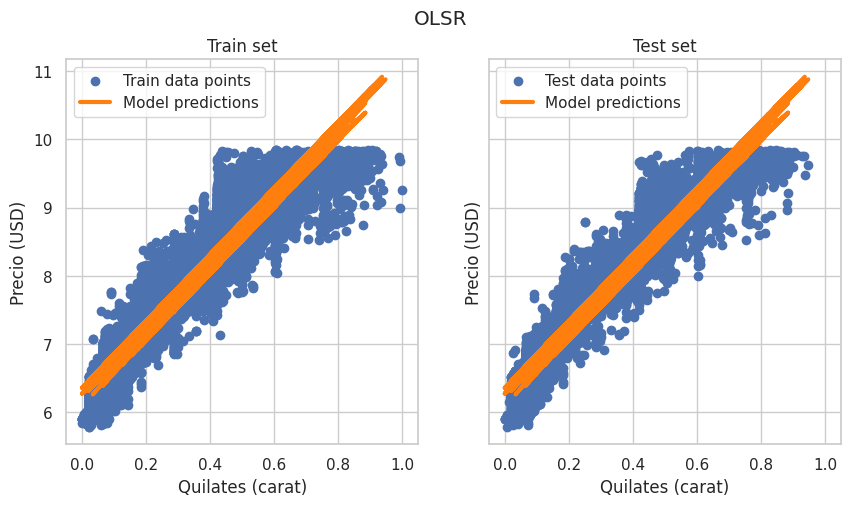

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].scatter(x_train['carat'], y_train_log, label="Train data points")
ax[0].plot(
    x_test['carat'], # Plot against test set carat values
    y_pred,
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel=column_labels['carat'], ylabel=column_labels['price'], title="Train set")
ax[0].legend()

ax[1].scatter(x_test['carat'], y_test_log, label="Test data points")
ax[1].plot(x_test['carat'], y_pred, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel=column_labels['carat'], ylabel=column_labels['price'], title="Test set")
ax[1].legend()

fig.suptitle("OLSR")

plt.show()

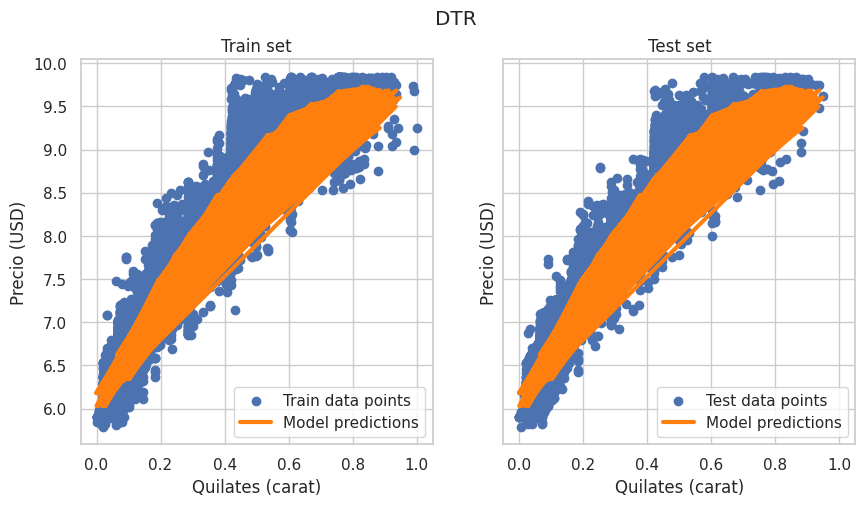

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].scatter(x_train['carat'], y_train_log, label="Train data points")
ax[0].plot(
    x_test['carat'], # Plot against test set carat values
    y_pred_log_tree,
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel=column_labels['carat'], ylabel=column_labels['price'], title="Train set")
ax[0].legend()

ax[1].scatter(x_test['carat'], y_test_log, label="Test data points")
ax[1].plot(x_test['carat'], y_pred_log_tree, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel=column_labels['carat'], ylabel=column_labels['price'], title="Test set")
ax[1].legend()

fig.suptitle("DTR")

plt.show()

___

# Parte 2 - Clasificación (50 puntos)

### Considere lo siguiente:
1. Conjunto de datos: **cardio.csv**
2. Algunos detalles del conjunto de datos los puede ver en: <https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset>.
3. El atributo a predecir es: **cardio**.
4. Proponga al menos dos algoritmos a utilizar
5. Métricas:
    1. Accuracy
    2. Ustedes propongan una más.
6. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso.
    2. Para cada uno de los algoritmos seleccionados:
        1. Explicación del algoritmo.
        2. Explicación de la implementación seleccionada y de sus parámetros (según la biblioteca).
    4. Explicación del diseño experimental por ejecutar. Recuerde que si el algoritmo requiere seleccionar hiperparámetros, hay que dividir en tres conjuntos de datos: Training, Validation, Testing (60%, 20%, 20%). Se le recomienda confirmar con el profesor cuántos y cuáles hiperparámetros validar.
    5. Programación del diseño experimental.
    6. Tablas de resultados, gráficos y conclusiones de los resultados, recomendando a su contratante cuál algoritmo utilizar, con qué configuración y por qué lo recomienda.

---